In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

In [3]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

In [4]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10


### Dataset's transformation

In [5]:
print('STEP 1: DEFINE DATASET')

train_dataset = dset.MNIST("./data/MNIST", train=True, 
                        transform = transforms.Compose(
                            # Zero pad with 6 -> size 40
                            [transforms.Pad(6),
                            # By RandomAffine, randomly rotate/scale image and place digit's location randomly(translate)
                            transforms.RandomAffine(degrees = (-45,45), translate = (0.3,0.3), scale=(0.7,1.2)),
                            # Zero pad with 20 -> size 80
                            transforms.Pad(20),
                            # Change to tensor
                            transforms.ToTensor(),
                            # Normalize data with MNIST data's mean and std
                            transforms.Normalize(0.1307,0.3081)]),
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST("./data/MNIST", train=False,
                        transform = transforms.Compose(
                            [transforms.Pad(6),
                            transforms.RandomAffine(degrees = (-45,45), translate = (0.3,0.3), scale=(0.7,1.2)),
                             transforms.Pad(20),
                            transforms.ToTensor(),
                            transforms.Normalize(0.1307,0.3081)]),
                        target_transform=None,
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)


/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


MNIST std:  tensor(0.3081)


In [6]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))


Train dataset size: 60000
Test dataset size: 10000


###  Visualize Dataset


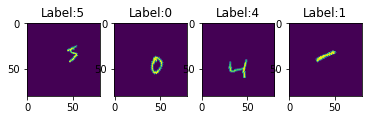

In [7]:
figure = plt.figure()

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2)
    if i == 3:
        plt.show()
        break

In [8]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


### STN_CNN Architecture

In [9]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')


class STN_CNN(nn.Module):

    def __init__(self):
        super(STN_CNN,self).__init__()
        
        self.cnn = nn.Sequential(
                    nn.AvgPool2d(kernel_size=2),
                    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=9, stride=1, padding=0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2)
                )
        self.classifier = nn.Sequential(
                    nn.Linear(1600,128),
                    nn.ReLU(),
                    nn.Linear(128,10)
                )
        self.localization = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=0),
                    nn.ReLU()
                )
        self.fc_loc = nn.Sequential(
                    nn.Linear(23120,20),
                    nn.ReLU(),
                    nn.Linear(20,6)
                )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        
    def STN(self,x):
        loc_x = self.localization(x)
        loc_x = loc_x.view(-1, 23120)
        theta = self.fc_loc(loc_x)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
        
        
    
    def forward(self,x):
        x = self.STN(x)
        
        # Perform the usual forward pass
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x



STEP 3: CREATE MODEL CLASS (STN_CNN)


In [10]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


In [11]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### Tirain the STN_CNN model and print accuracy for every epochs


In [12]:
print('STEP 6: INSTANTIATE LOSS CLASS')
# Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Model to GPU
model.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        img, label = img.to(device0), label.to(device0)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        print(img.shape)
        # Forward pass to get output/logits
        outputs = model(img)
        print(outputs.shape)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, label)
        print(outputs.shape, label.shape)
        print("outputs: ", outputs)
        print("label: ", label)
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
           
                    
    #Test
    model.eval()
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device0), target.to(device0)
            output = model(data)

            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(test_loader.dataset)
    
    
    
    
    print('Test set accuracy: {}/{} ({:.2f}%)'.format(correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
    
    
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
torch.Size([256, 1, 80, 80])


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


torch.Size([256, 10])
torch.Size([256, 10]) torch.Size([256])
outputs:  tensor([[-0.0081,  0.0112, -0.0620,  ..., -0.0810, -0.0481,  0.0529],
        [ 0.0270,  0.0176, -0.0326,  ..., -0.0256, -0.0095,  0.0301],
        [ 0.0366,  0.0081, -0.0155,  ..., -0.0445, -0.0475,  0.0999],
        ...,
        [ 0.0425,  0.0032,  0.0069,  ..., -0.0082, -0.0058,  0.0684],
        [ 0.0108,  0.0142, -0.0159,  ..., -0.0247, -0.0160,  0.0390],
        [ 0.0157,  0.0172, -0.0166,  ..., -0.0471, -0.0412,  0.0729]],
       device='cuda:0', grad_fn=<AddmmBackward>)
label:  tensor([3, 8, 8, 7, 3, 0, 3, 1, 7, 9, 2, 3, 2, 3, 1, 2, 1, 5, 7, 3, 5, 4, 2, 0,
        6, 1, 6, 1, 2, 1, 2, 4, 7, 3, 1, 3, 5, 8, 6, 7, 2, 4, 5, 6, 9, 0, 0, 6,
        1, 2, 1, 0, 7, 9, 9, 3, 0, 0, 8, 7, 2, 1, 8, 0, 1, 8, 0, 1, 7, 3, 5, 7,
        7, 0, 8, 4, 4, 1, 9, 9, 6, 7, 2, 3, 6, 4, 5, 4, 6, 7, 1, 2, 6, 2, 5, 2,
        4, 6, 0, 8, 9, 2, 3, 2, 7, 3, 3, 8, 2, 4, 1, 0, 2, 7, 4, 7, 4, 2, 7, 6,
        7, 7, 4, 9, 4, 4, 4, 9, 3, 4,

KeyboardInterrupt: 

#### Pretrained model's best accuracy

In [22]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

Best accuracy of our model with ST module:  98.99


In [25]:
# Tensor image to array image

def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)
    
    return img_re


#### Visualization of original inputsa and transformed inputs

In [26]:
class VisualizeSTN():
    
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
        out = self.model.STN(x)
        return out
    
    def visualize(self, img):
        
        with torch.no_grad():
            input_tensor = img.to(device0)
            # do forward_stn -> output is transformed inputs
            transformed_input_tensor = self.forward_stn(img).to(device0)
            
            # Plot 16 images to 4x4 so nrow is 4  
            in_grid = reprocess_image(
                v_utils.make_grid(input_tensor,nrow=4))

            out_grid = reprocess_image(
                v_utils.make_grid(transformed_input_tensor,nrow=4))

            # Plot the results side by side
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(in_grid)
            axarr[0].set_title('Original Images')

            axarr[1].imshow(out_grid)
            axarr[1].set_title('Transformed Images')
        

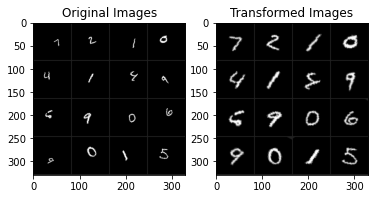

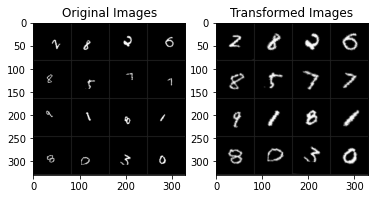

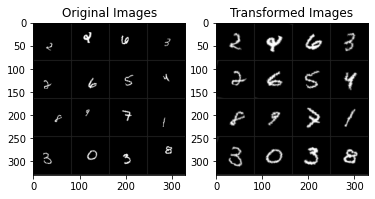

In [27]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break


### Comparison with the cnn model without ST module 

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # STN module parts - localization, fc_loc - are removed from STN_CNN class
        self.cnn = nn.Sequential(
                    nn.AvgPool2d(kernel_size=2),
                    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=9, stride=1, padding=0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=0),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2)
                )
        self.classifier = nn.Sequential(
                    nn.Linear(1600,128),
                    nn.ReLU(),
                    nn.Linear(128,10)
                )
        
    def forward(self,x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x


In [29]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])


In [30]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### Train/Test

In [31]:
print('STEP 6: INSTANTIATE LOSS CLASS')
# Use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Model to GPU
model_nostn.to(device0)


print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        img, label = img.to(device0), label.to(device0)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model_nostn(img)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, label)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
    scheduler.step(loss)
           
                    
    #Test
    model_nostn.eval()
    
    with torch.no_grad():
        model_nostn.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device0), target.to(device0)
            output = model_nostn(data)

            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(test_loader.dataset)
    
    
    
    
    print('Test set accuracy: {}/{} ({:.2f}%)'.format(correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
    
    
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_nostn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './without_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.299354  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.934326  
Test set accuracy: 7473/10000 (74.73%)
////Epoch elapsed time: 12.100653171539307////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.826370  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.610700  
Test set accuracy: 8469/10000 (84.69%)
////Epoch elapsed time: 7.3319315910339355////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.622699  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.442621  
Test set accuracy: 8887/10000 (88.87%)
////Epoch elapsed time: 7.112313985824585////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.265392  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.327527  
Test set accuracy: 9033/10000 (90.33%)
////Epoch elapsed time: 7.884948492050171////

Train Epoch: 4 [0/60000 (0%) / Lear

In [32]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  97.5


### Discussion

> Best accuracy of model with ST module is 98.99%, which is about 1.5% higher than that of model without ST module. From this result, we can say that ST module helps model's learning.

### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>